In [1]:
#import panel as pn
#pn.extension()
import ipywidgets as widgets

# What's In A Name? Investigating Bias And Identity In Text-To-Image Models

## Introduction

This work will investigate the relationships between names and biases in text to image models. some narrower topics of interest include:

* constructing measures for characterizing the degree to which a model has learned the relationship between a name and specific entity
* measuring biases associated with names that are not tightly bound to identities
* characterizing how biases of these kinds can be composed into new identities
* characterizing the "stickiness" of specific attribute biases to identities/names
* investigating the potential for leveraging these measure to monitor training progress for personalization finetuning and general purpose pre-training


* biases in names
* known identities ("strong entities")
* overfitted identities (memorized images)
  * mona lisa?

* Just investigating biases, not making normative statements

* associated hypotheses
* out of scope hypotheses (future work)

## Hypotheses

1. The more weakly a name carries learned biases, the more closely the distribution of attributes observed when prompting that name approximates the model's global prior for the biases in those attributes. Consequence: low bias names can be used to probe model bias (assuming such names can be identified). Validate by demonstrating proximity to distribution of identities generated by ambiguous prompts like "wow" generated with low CFG (i.e. close to null prompt)

2. "pseudo-identities" can be composed for prompt-engineering in text space, similar to how celeb-basis composes identities in token space.

3. "Identity strength" can be quantified wrt...
  * rigidity of distribution of attributes generated by a given(fixed) prompt
  * flexibility to prompt identity into new scenarios (e.g. "sks shaking hands with albert einstein")

4. identity evolves following a particular pattern, and monitoring this pattern can be used to evaluate model fit/grokking (e.g. for LoRA). There may be certain identities that are better or worse suited for use as "canaries" of this kind to monitor model fit progress.
  
5. identity/bias-preserving representations can be crystallized from pre-trained representations, and leveraging these should permit measuring identity strength/rigidity more efficiently than with "un-crystallized" pre-trained representations.

6. Biases in first names and family names will reflect certain "unsurprising" correlations picked up by the model, such as:
  * racial biases for "ethnic" names
  * age/era biases corresponding to baby name popularity

7. There should be properties about how identities are represented within text-to-image models that should permit us to mine these models for strongly represented identities by interrogating model weights/activations separately from the measures we develop here that operate on the representational space of generated images.

    b. Some fraction of these identitites/biases are identifiable by interrogating the input text embeddings. I.e. some of these identifies dominate one or two tokens and there should be a query we can bounce off the token like "is person" that we can use to classify tokens associated with identities and/or which are candidates for constructing identities compositionally

## Properties of "strong identities"

* fixed eye color, hair color, chin shape
* common elements caricatured

There are two classes of "identities" that I characterize as "strong" here:

* The model generates images that are seemingly consistent to a prompt and which *do* correspond to a specific unique person.
* The model generates images that are seemingly consistent to a prompt and which are simply self-consistent, but it's unlikely the model has actually learned an actual "identity" corresponding to the prompted name but is rather composing the identity from biases it learned.
  * This latter case is more difficult to distinguish when generating images with first names only. The important thing is to note that we are only interested in self-consistent identities and are not concerned with whether or not the images the model generates actually correspond to a real person, whether associated with the corresponding name or otherwise.
  
For the purposes of this analysis, an identity is considered "strong" with respect to the model's consistency when generating images of people with the corresponding prompt. We consider this strength only from the model's perspective, without reference to the "outside world". Identities need not be veridical to be considered "strong" for these purposes.

## Methodology [wip]

* choosing names
* generating images
* todo: regenerate if image doesn't contain exactly one human face

## Experiments

* calibrating minimum # images
* investigating which embedding representation to use
* experimenting with summary statistics

## Insights

* presumptive phases of bias formation
* correlation between age bias and popularity of names by birth year
* strength of ethnic bias reflects undersampled data class
  * strong biases hint at low data cardinality for the given class


## Discussion


## Future Work

* Where do these biases live? 
  * Hypothesis: identities primarily reflect biases in the CLIP text encoder
  * TO DO: validate this. open question: how? CLIP text to images centroid similarity? gotta interrogate some aspect of the text embeddings. or CLIP activations.
* Can we disentangle or decompose these biases?
* Normative analysis. 
  * If biases are reflective of real measurable biases associated with names in the population (e.g. race), are they problematic?
    * positive: use of generative models to examine societal biases crystalized in the learned representations
    * negative: use of generative models to infer properties for discriminatory purposes, e.g. job applicant race/gender
* Names atlas
  * build image dataset from a larger set of names.
  * collect names specifically aiming for "bias recall", i.e. go out of our way to ensure e.g. south east asian names, arab names, african names are represented.
  * could be used as a tool for prompt engineering
  * could be used for generating more diverse training data
  * could be used to train models that deliberately break associations between names and identity biases (whether or not this is necessarily a good idea)

## References

* CLIP
* Stable Diffusion
* Stable Biases
* Celeb Basis

## Appendix

* Calibration plots
* DINO-vits stuff (assuming DINO-vitg shows in main report)


# Generating Images

## Collecting Names

a dataset of images was generated to interrogate the biases in the associated prompts. For an initial small dataset, names identified as useful in the Celeb Basis experiment were utilized (`celebs.txt`) to start from a base of names that were known to have representational biasesof varying strengths  associated. Rather than utilizing the whole name, we take only the first name to get a distribution over bias strengths. This procedure produced a list of 107 first names which was used to prototype our experimental methods.

Images were generated using stable diffusion v1.4 via huggingface's Diffuser's library. For each name, 128 images were generated using the prompt: `"a photo of {name}, portrait photography, full color, face full frame"`. The number 128 was arrived at by spot checking the convergence of naive "identity strength" measures and determining that 128 images provided a reasonable baseline for low variance measurement.

Future work: In the experimentation that motivated this work, it was observed that 4-8 images are generally sufficient for an expert prompter to distinguish "strong identities" from "pseudo-identities". 128 images should be interpreted as an extremely conservative upper bound, and we look forward to future works that identify or construct measures that are able to distinguish identity strength and bias rigidity in prompts using fewer images.

# Measuring Strength of Identities in Prompts

For a simple baseline, we compute `n` images for a given prompt, project these images into a shared representation space, compute the centroid of the representations for that prompt, and score the prompt as the mean distance from the centroid to the generated images' representations. We chose a conservative value of `n=128` for this work to promote stability of our naive benchmarking metric relative to any given identity.

<!-- move DINO discussion to appendix -->

Initial experiments projected into pre-trained DINOv2 representations. Representation utility was evaluated by ranking names relative to the "identity strength" measure using that representational space, and evaluating qualitatively if strong identities received higher scores than weaker identities. We observed that the smallest DINO model we tried performed better than the largest, but that niether model produced satisfactory representations. Weakness of representations for our purpose was validated by observing the relationship between UMAP clustering of the images in the representational space and the expected correspondence of these clusters to identities. DINO produced a space with meaningful clusters per UMAP, but these clusters generally did not correspond to prompts/identities in the way we hoped.

![DINO sucks for this](fml.png)

The next representational space we tried was CLIP-ViT-B/32. We observed better performance qualitatively, and the improved utility of these representations was validated by observing consistent coloring of UMAP clusters correlated with strong identity prompts.

![CLIP UMAP Identities](./clip-ftw.png)

In [2]:
import pandas as pd

df_names = pd.read_csv('2023-09-25_names_ranked.csv')
df_names.head()

,name,similarity@128
0,rihanna,0.922737
1,kanye,0.921163
2,beyoncé,0.905713
3,oprah,0.904635
4,madonna,0.901482


In [3]:
df_names.tail()

,name,similarity@128
102,lionel,0.700712
103,robin,0.700462
104,dante,0.696849
105,bruce,0.696610
106,roger,0.683294


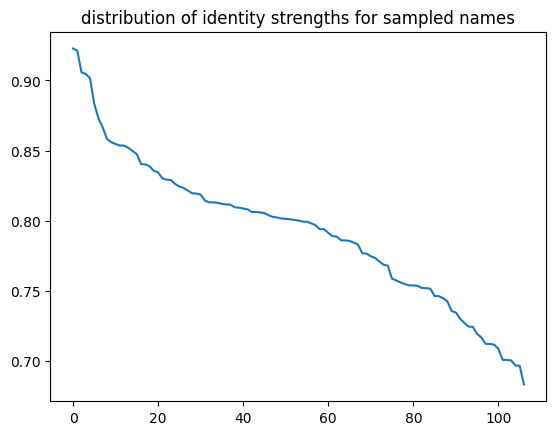

In [4]:
import matplotlib.pyplot as plt
plt.plot(df_names['similarity@128'])
plt.title("distribution of identity strengths for sampled names")
plt.show()

In [49]:
#https://stackoverflow.com/a/71315656/819544
def concat_images(*images):
    """Generate composite of all supplied images."""
    from PIL import Image
    height = max(image.height for image in images)
    width = sum(image.width for image in images)
    composite = Image.new('RGB', (width, height))
    # Paste each image below the one before it.
    y = 0
    for image in images:
        #composite.paste(image, (0, y))
        composite.paste(image, (y,0))
        #y += image.height
        y += image.width
    return composite

madonna - 0.9014818


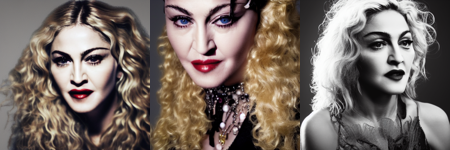

rihanna - 0.9227371


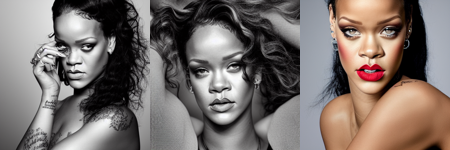

oprah - 0.9046353


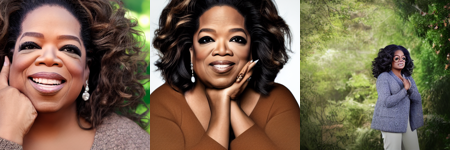





lilly - 0.8535862


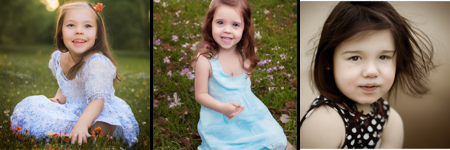

yuvraj - 0.8535409


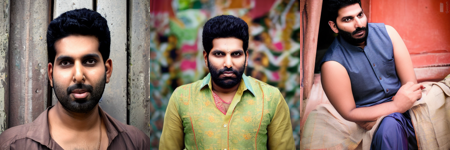

keanu - 0.8546753


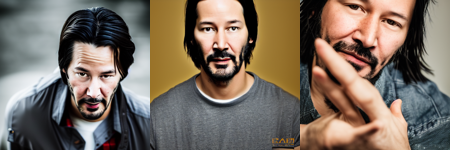





julia - 0.8087107


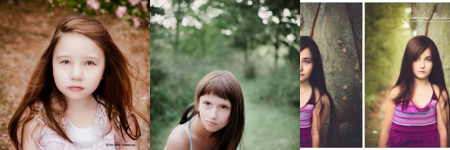

amol - 0.8016052


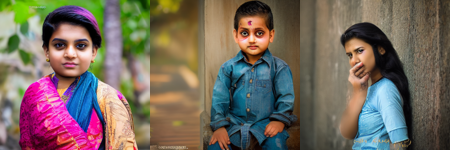

cristiano - 0.8214518


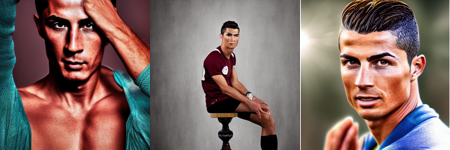





kim - 0.7860777


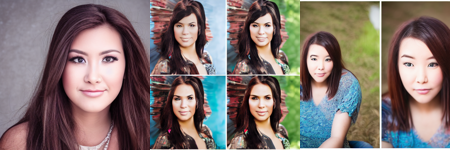

george - 0.7940337


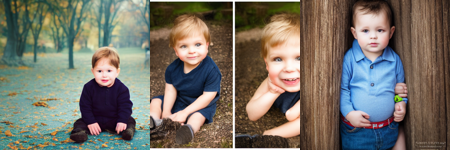

dwayne - 0.75392973


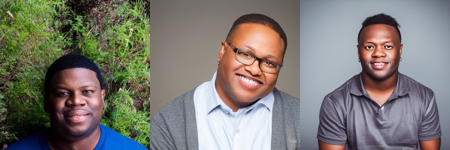





robin - 0.7004619


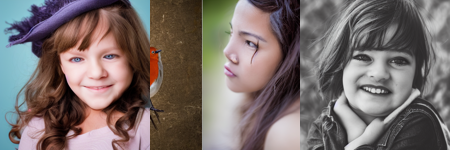

dennis - 0.7008914


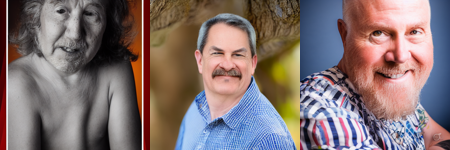

steven - 0.7462739


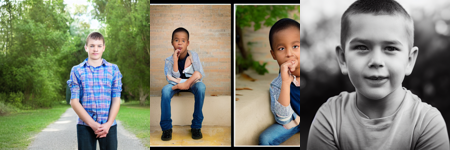





dante - 0.69684917


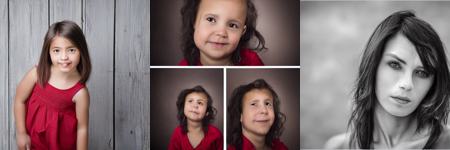

roger - 0.68329424


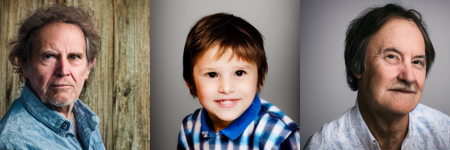

bruce - 0.6966102


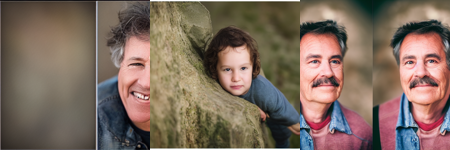

In [52]:
# to do: sample images at different identity strength buckets
# Based on plot, seem reasonable to do buckets in increments of 0.05

from pathlib import Path
import random
from IPython import display
import PIL

random.seed(42)

panes=[]

images_per_identity = 3

high_bar = 0.95
while high_bar > .65:
    low_bar = high_bar - .05
    test1 = high_bar >= df_names['similarity@128']
    test2 = df_names['similarity@128'] > low_bar
    df_bucket = df_names[test1 & test2].sample(3)
    #print(df_bucket)
    high_bar = low_bar
    
    
    for _, (name, val) in df_bucket.iterrows():
        #print(name)
        print(f"{name} - {val}")
        outdir = Path('images')/ f"a_photo_of_{name}_portrait_photography_full_color_face_full_frame"
        im_fpaths = list(outdir.glob("*.png"))
        im_fpaths = random.choices(im_fpaths, k=images_per_identity)
        #print(im_fpaths)
        ims4name=[]
        for im in im_fpaths:
            # maybe it'll store the images smaller if we resize first
            #display.display(display.Image(im, height=72, width=72))
            
            im=PIL.Image.open(im)
            im=im.resize((150,150))
            #image=im.tobytes()
            
            #with im.open('rb') as f:
            #    image = f.read()
            
            # im = widgets.Image(
            #     value=image,
            #     format='png',
            #     width=100,
            #     height=100,
            # )
            #display.display(im)
            #ims4name.append(im)
            #ims4name.append(pn.pane.PNG(im, embed=True)) # embed not working
            #ims4name.append(widgets.Image(value=im))
            ims4name.append(im)
        #panes.append(pn.Row(f"{name} - {val}"))
        #panes.append(pn.Row(*ims4name))
        #panes.append(f"{name} - {val}")
        #panes.append(widgets.HBox(ims4name))
        #panes.append(concat_images(*ims4name))
        display.display(concat_images(*ims4name))
    print("\n\n\n")
    #panes.append(pn.layout.Divider())

#pn.Column(*panes)
#widgets.VBox(panes)